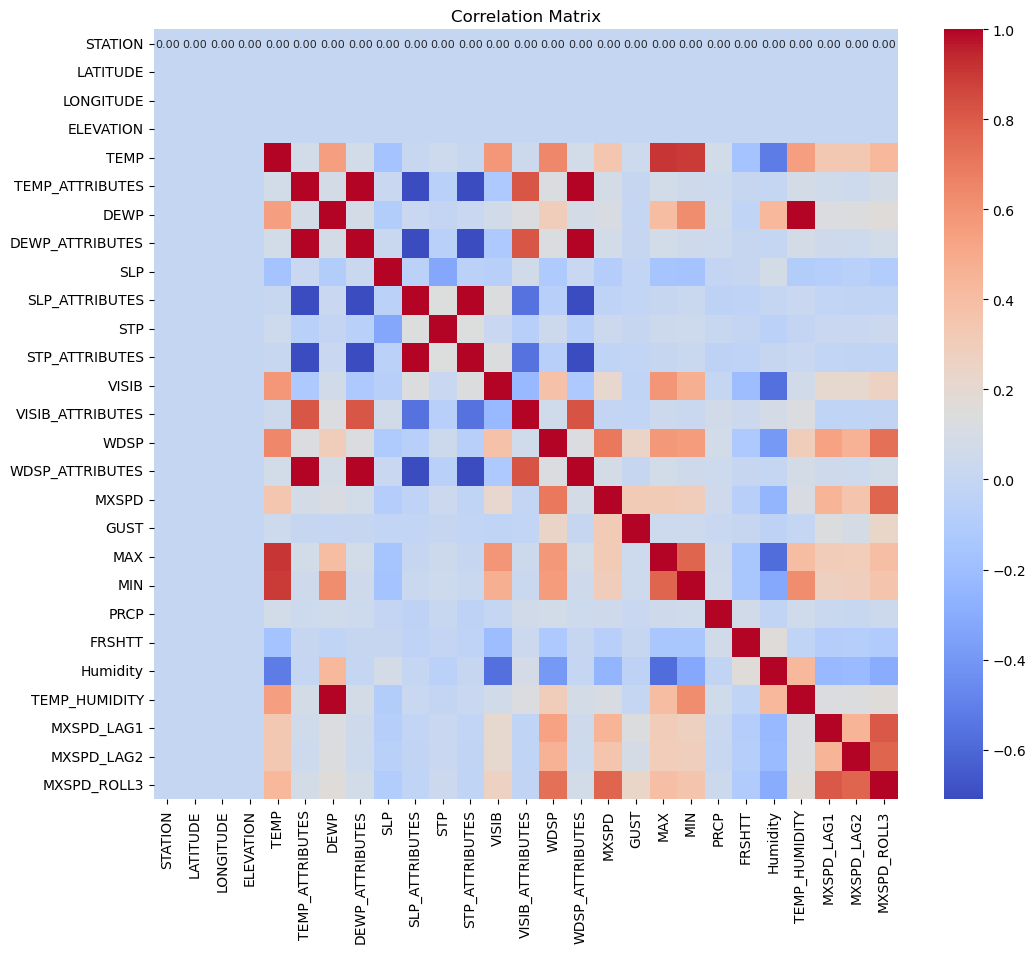

Selected Features: ['TEMP' 'DEWP' 'PRCP' 'Humidity' 'Month' 'Day' 'TEMP_HUMIDITY'
 'MXSPD_LAG1' 'MXSPD_LAG2' 'MXSPD_ROLL3']
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1344
[LightGBM] [Info] Number of data points in the train set: 6127, number of used features: 10
[LightGBM] [Info] Start training from score 11.445830
Training until validation scores don't improve for 20 rounds
[10]	valid_0's rmse: 2.79975	valid_0's l2: 7.83859
[20]	valid_0's rmse: 2.61197	valid_0's l2: 6.82241
[30]	valid_0's rmse: 2.4447	valid_0's l2: 5.97654
[40]	valid_0's rmse: 2.29481	valid_0's l2: 5.26616
[50]	valid_0's rmse: 2.16395	valid_0's l2: 4.68267
[60]	valid_0's rmse: 2.04866	valid_0's l2: 4.19701
[70]	valid_0's rmse: 1.9415	valid_0's l2: 3.76942
[80]	valid_0's rmse: 1.85978	valid_0's l2: 3.45878
[90

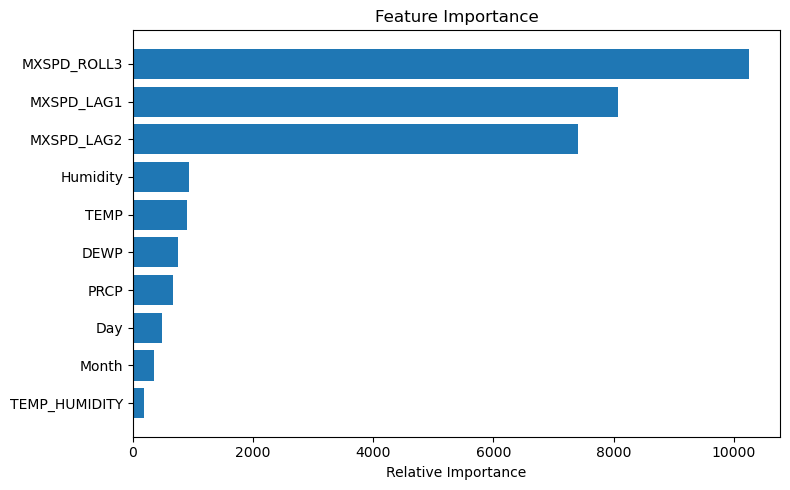

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.feature_selection import SelectKBest, f_regression

# Load and preprocess the data
data = pd.read_csv("cleaned_weather_data.csv")
data['DATE'] = pd.to_datetime(data['DATE'], errors='coerce')
data.dropna(subset=['DATE', 'MXSPD'], inplace=True)

# Fill missing values
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

# Feature engineering
data['Month'] = data['DATE'].dt.month
data['Day'] = data['DATE'].dt.day
data['DayOfWeek'] = data['DATE'].dt.weekday
data['TEMP_HUMIDITY'] = data['TEMP'] * data['Humidity']
data['MXSPD_LAG1'] = data['MXSPD'].shift(1)  # Lagged wind speed
data['MXSPD_LAG2'] = data['MXSPD'].shift(2)
data['MXSPD_ROLL3'] = data['MXSPD'].rolling(3).mean()  # Rolling average
data.drop(columns=['DATE'], inplace=True)
data.dropna(inplace=True)  # Drop rows with NaNs from rolling or lagged features

# Correlation matrix visualization
plt.figure(figsize=(12, 10))
numeric_data = data.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_data.corr().fillna(0)  # Replace NaNs with zeros
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", annot_kws={"size": 8})
plt.title("Correlation Matrix")
plt.show()

# Define features and target
features = ['TEMP', 'DEWP', 'PRCP', 'Humidity', 'Month', 'Day', 'DayOfWeek', 
            'TEMP_HUMIDITY', 'MXSPD_LAG1', 'MXSPD_LAG2', 'MXSPD_ROLL3']
target = 'MXSPD'
X = data[features]
y = data[target]

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature selection
selector = SelectKBest(score_func=f_regression, k=10)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = np.array(features)[selector.get_support()]
print("Selected Features:", selected_features)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# LightGBM model setup
lgbm_model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=8,
    min_child_samples=5,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)



# Train the model with early stopping
lgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[
        early_stopping(stopping_rounds=20),
        log_evaluation(10)
    ]
)

# Model evaluation
final_y_pred = lgbm_model.predict(X_test)
final_mse = mean_squared_error(y_test, final_y_pred)
final_r2 = r2_score(y_test, final_y_pred)

print(f"Final MSE: {final_mse}")
print(f"Final R² Score: {final_r2}")

# Plot feature importance
feature_importances = lgbm_model.feature_importances_
sorted_idx = np.argsort(feature_importances)

plt.figure(figsize=(8, 5))
plt.barh(range(len(feature_importances)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(feature_importances)), selected_features[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()